In [1]:
import sys
sys.path.append('../')
import torch.optim as optim
from dataset import *
from model import *
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter

Train_epoch:0    MAE:108.09698205566406   Pure:107.99622181396484
Train_epoch:10    MAE:6.343477991485596   Pure:5.991156432342529
Test_epoch:10    MAE_test:12.107607236685464


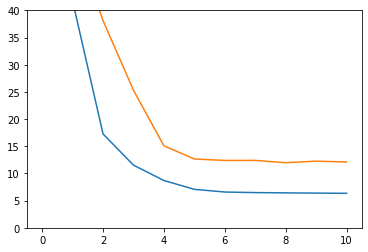

Train_epoch:20    MAE:5.516840265655517   Pure:5.143378983688354
Test_epoch:20    MAE_test:10.317406986468136


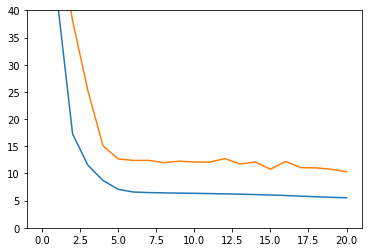

Train_epoch:30    MAE:5.267464861679077   Pure:4.892847554397583
Test_epoch:30    MAE_test:7.453485970299084


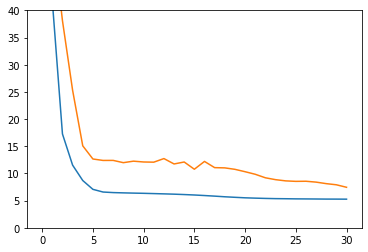

Train_epoch:40    MAE:5.21761594543457   Pure:4.8482554916381835
Test_epoch:40    MAE_test:6.7514511053554545


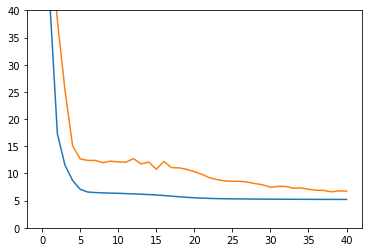

Train_epoch:50    MAE:5.203032579040527   Pure:4.838242614364624
Test_epoch:50    MAE_test:6.246605388653545


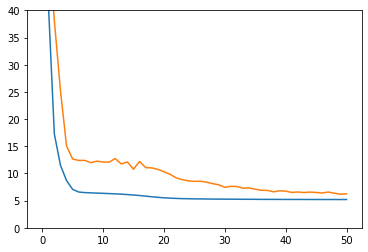

Train_epoch:60    MAE:5.192567175292969   Pure:4.831382989120484
Test_epoch:60    MAE_test:6.586751986616336


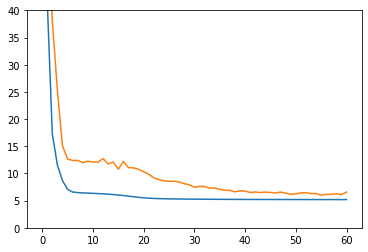

Train_epoch:70    MAE:5.183781992340088   Pure:4.8262840789794925
Test_epoch:70    MAE_test:6.297239705777397


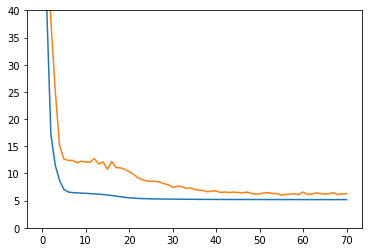

Train_epoch:80    MAE:5.180258491134643   Pure:4.8261422973632815
Test_epoch:80    MAE_test:6.082009557717905


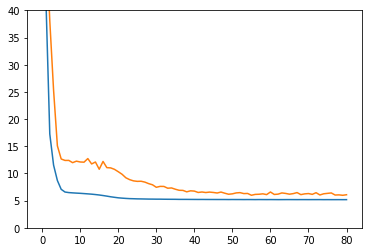

Train_epoch:90    MAE:5.159379416656495   Pure:4.809130682754517
Test_epoch:90    MAE_test:5.9900989044969455


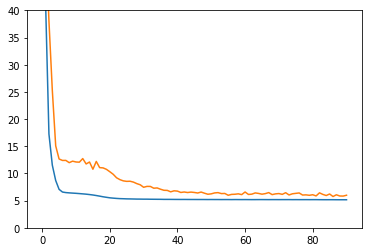

Train_epoch:100    MAE:5.148394841003418   Pure:4.801934168243408
Test_epoch:100    MAE_test:6.402576481572355


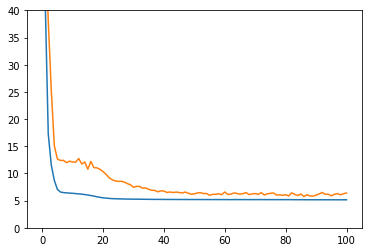

Train_epoch:110    MAE:5.151824085617066   Pure:4.808683645248413
Test_epoch:110    MAE_test:6.2461657783093925


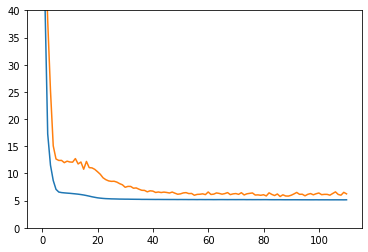

Train_epoch:120    MAE:5.127719877243042   Pure:4.787663849258423
Test_epoch:120    MAE_test:6.046425401974029


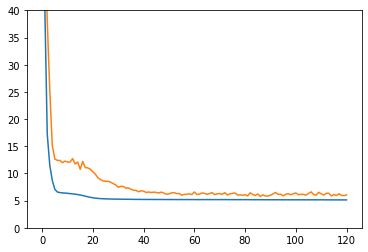

Train_epoch:130    MAE:5.111061720657348   Pure:4.774213919830323
Test_epoch:130    MAE_test:6.316035150339047


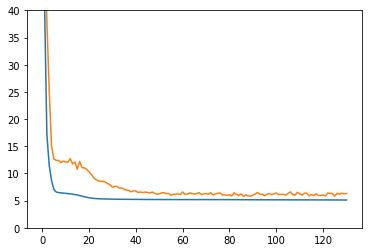

Train_epoch:140    MAE:5.08580274848938   Pure:4.752167110443115
Test_epoch:140    MAE_test:6.043401689194262


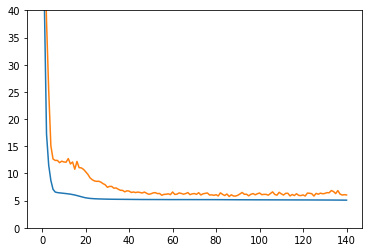

Train_epoch:150    MAE:5.064285694503784   Pure:4.73402257194519
Test_epoch:150    MAE_test:6.751697429071981


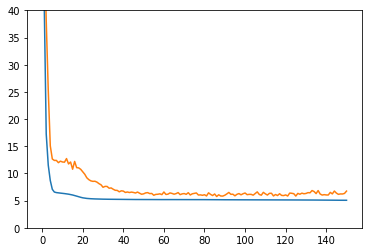

Train_epoch:160    MAE:5.038668606185913   Pure:4.710617330169677
Test_epoch:160    MAE_test:6.210645494369653


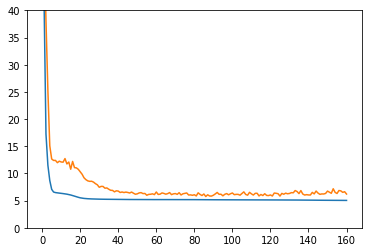

Train_epoch:170    MAE:4.956313283538818   Pure:4.630841387939453
Test_epoch:170    MAE_test:6.877558691433062


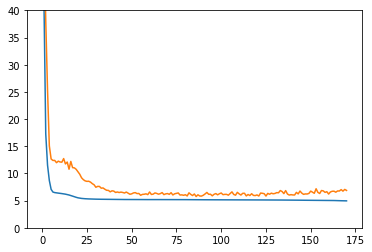

Train_epoch:180    MAE:4.917841584777832   Pure:4.593605805587768
Test_epoch:180    MAE_test:7.380840711319409


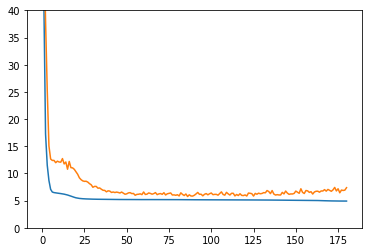

Train_epoch:190    MAE:4.905332727813721   Pure:4.581795035171509
Test_epoch:190    MAE_test:7.261518239213255


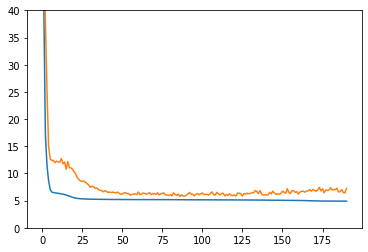

Train_epoch:200    MAE:4.899809858703613   Pure:4.5773072265625
Test_epoch:200    MAE_test:6.902177740590641


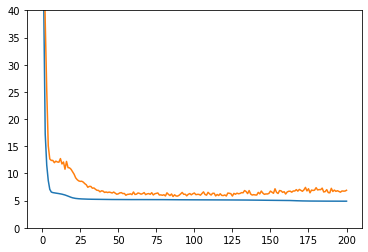

Train_epoch:210    MAE:4.891946419525146   Pure:4.570937679290772
Test_epoch:210    MAE_test:6.6526843808329525


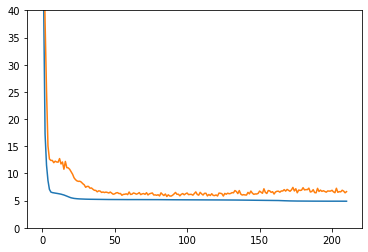

Train_epoch:220    MAE:4.89266858253479   Pure:4.573260405349732
Test_epoch:220    MAE_test:7.112313334553386


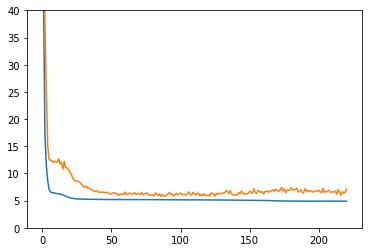

Train_epoch:230    MAE:4.888043925094604   Pure:4.570431916427612
Test_epoch:230    MAE_test:6.4851630290095414


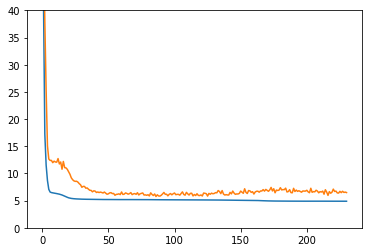

Train_epoch:240    MAE:4.8906632419586185   Pure:4.574821585845947
Test_epoch:240    MAE_test:6.804740680292392


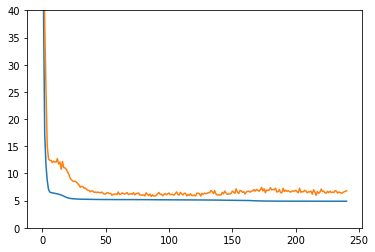

KeyboardInterrupt: 

In [2]:
s_or_d = "s"
unrelated_feature_number = 0
feature_number = 3

train_log = np.array([])
test_log = np.array([])

# writer = {
#     'train': SummaryWriter('../logs/OTO/train'), #必须要不同的writer
#     'test': SummaryWriter('../logs/OTO/test'),
# }

batchsize = 32
lambda_l1 = 0.005  # 正则化系数
lambda_selection = 0

criterion = nn.L1Loss()
criterion = criterion.cuda()

model = MLP(feature_number).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# adaptive learning rate
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)


# tmp = np.load("../data/simu_20000_0.1_90_140_train.npy")
# if s_or_d == 0:
#     max = np.max(tmp[:, 1004])
#     min = np.min(tmp[:, 1004])
# else:
#     max = np.max(tmp[:, 1005])
#     min = np.min(tmp[:, 1005])


train_dataset = Dataset("../data/features_rand_train.npy", s_or_d, "train", unrelated_feature_number)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = Dataset("../data/features_rand_test.npy", s_or_d, "test", unrelated_feature_number)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

for epoch in range(501):
    
    # print(f"Learning Rate (Single LR): {optimizer.param_groups[0]['lr']}")
    
    model.train()

    loss_total = 0
    step = 0
    loss_pure = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        # print(data.shape)

        # target = (target - min) / (max - min)

        output = model(data)

        loss = criterion(output, target)
        
        loss_pure = loss_pure + loss.item()
        
        l1_regularization = torch.tensor(0.0).cuda()
        l1_selection = torch.tensor(0.0).cuda()
        
        for param in model.seq.parameters():
            l1_regularization += torch.norm(param, p=1)
        
        # for param in model.OneToOneLayer.parameters():
        #     l1_selection += torch.norm(param, p=1)
        
        loss = loss + l1_regularization * lambda_l1 + l1_selection * lambda_selection

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total = loss_total + loss.item()
        step = step + 1
    
    # scheduler.step()
    
    # writer["train"].add_scalar('FS', loss_total/step, epoch)  
    train_log = np.append(train_log, loss_total/step)
    
    # tmp = '../pth/tmp_%d_%.2f.pth' % (epoch, loss_total/step)
    
    if epoch % 10 == 0:
        # torch.save(model, tmp)
        print("Train_epoch:" + str(epoch) + "    MAE:" + str(loss_total/step) + "   Pure:" + str(loss_pure/step))

    loss_test = 0
    step = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)

            # inv_norm
            # output = output * (max - min) + min

            loss = criterion(output, target)

            loss_test += loss.item()
            step += 1

        loss_mean = loss_test / step
        
        # writer["test"].add_scalar('FS', loss_mean, epoch) 
        test_log = np.append(test_log, loss_mean)
        
        if epoch % 10 == 0 and epoch != 0:
            print("Test_epoch:" + str(epoch) + "    MAE_test:" + str(loss_mean))
            # tmp_epoch = np.arange(epoch+1)
            # print(tmp_epoch)
            plt.plot(train_log)
            plt.plot(test_log)
            plt.ylim(0,40)
            plt.show()
            